In [1]:
import sys
import pyccl as ccl
import pickle

import camb
from camb import model, initialpower
# sys.path.insert(0,'../skylens/')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy
from skylens import *

In [7]:
LC,scheduler_info=start_client(local_directory='../temp/CCL_comp/')

error in creating local directory:  ../temp/CCL_comp/ [Errno 17] File exists: '../temp/CCL_comp/'


In [8]:
client=client_get(scheduler_info)

In [9]:
#setup parameters
lmax_cl=4000
lmin_cl=2
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=False
bin_cl=False

SSV_cov=False
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [10]:
zg_bin1=lsst_source_tomo_bins(ns0=26,nbins=2)

ns0:  26.0


In [11]:
z0=1
# zs_bin1=source_tomo_bins(zp=[z0,z0+1],p_zp=np.array([1,1]),ns=26)
zs_bin1=zg_bin1

In [12]:
SSV_cov,do_cov

(False, False)

In [13]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
corrs=[corr_ll,corr_ggl,corr_gg]


In [57]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'OmR':cosmo.Ogamma0+cosmo.Onu0,'w':-1,'wa':0,'Tcmb':cosmo.Tcmb0,
                'Ase9':2.2,'mnu':0,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,
                })
cosmo_fid['Oml']=1.-cosmo_fid['Om']-cosmo_fid['Omk']
pk_params={'non_linear':1,'kmax':30,'kmin':3.e-4,'nk':500,'scenario':'dmo','pk_func':'camb_pk_too_many_z','halofit_version':'takahashi'}
power_spectra_kwargs={'pk_params':pk_params,'cosmo_params':cosmo_fid}

In [58]:
cosmo_fid

{'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'OmR': 0.001490168473904707,
 'w': -1,
 'wa': 0,
 'Tcmb': <Quantity 2.7255 K>,
 'Ase9': 2.2,
 'mnu': 0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'Oml': 0.6925}

In [59]:
#use all ell
kappa0=Skylens(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=None,l=l0, zg_bins=zg_bin1,#z_PS=zg['z'],
               use_window=False,do_pseudo_cl=False,galaxy_bias_func='constant_bias',corrs=corrs,nz_PS=100,
                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,power_spectra_kwargs=power_spectra_kwargs)#f_sky=0.35,sigma_gamma=0.37)

pk_params_eh={'non_linear':1,'kmax':30,'kmin':3.e-4,'nk':500,'scenario':'dmo','pk_func':'eh_pk'}
power_spectra_kwargs_eh={'pk_params':pk_params_eh,'cosmo_params':cosmo_fid}
kappa0_eh=Skylens(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=None,l=l0, zg_bins=zg_bin1,#z_PS=zg['z'],
               use_window=False,do_pseudo_cl=False,galaxy_bias_func='constant_bias',corrs=corrs,
                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,power_spectra_kwargs=power_spectra_kwargs_eh)#f_sky=0.35,sigma_gamma=0.37)

power spectra camb_pk_too_many_z
Win gen: step size 9 False False 3998 31.0
Window done. Size: 0.0
power spectra eh_pk
Win gen: step size 9 False False 3998 31.0
Window done. Size: 0.0


In [60]:
cosmo_params_ccl={'Omega_c':kappa0.Ang_PS.PS.cosmo_params['Omd'],
                  'Omega_b':kappa0.Ang_PS.PS.cosmo_params['Omb'],
                  'h':kappa0.Ang_PS.PS.cosmo_params['h'],
                  'sigma8':None,
                  'A_s':kappa0.Ang_PS.PS.cosmo_params['Ase9']*1.e-9,
                  'n_s': kappa0.Ang_PS.PS.cosmo_params['ns'],
                  'm_nu':kappa0.Ang_PS.PS.cosmo_params['mnu'],
                 'transfer_function':'boltzmann_camb', 'matter_power_spectrum':'linear'}
if pk_params['non_linear']==1:
    cosmo_params_ccl['matter_power_spectrum']='halofit'
cosmo_ccl = ccl.Cosmology(**cosmo_params_ccl)

In [61]:
#this function will generate and return CCL_tracer objects and also compute the noise for all the tracers
def get_tracer_info(kappa0,cosmo):
    ccl_tracers={tracer:{}for tracer in kappa0.tracer_utils.tracers}
    for tracer in kappa0.tracer_utils.tracers:
        tracer_dat=client.gather(kappa0.tracer_utils.z_bins[tracer])
        nbins=tracer_dat['n_bins']
        for i in np.arange(nbins):
            z= tracer_dat[i]['z']
            b = tracer_dat[i]['b1']*np.ones(len(z)) #Galaxy bias (constant with scale and z)
            AI = tracer_dat[i]['AI']*np.ones(len(z)) #Galaxy bias (constant with scale and z)
            dNdz = tracer_dat[i]['pz']
            mag_bias=tracer_dat[i]['mag_fact']*np.ones(len(z))
            if 'shear' in tracer:
                ccl_tracers[tracer][i]=ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz),ia_bias=(z,AI)) #CCL automatically normalizes dNdz
            elif 'galaxy' in tracer:
                ccl_tracers[tracer][i]=ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))#,mag_bias=(z,mag_bias))
    return ccl_tracers

In [62]:
def get_ccl_corr(kappa0,ccl_tracers,cosmo_ccl):
    ccl_corrs={corr:{} for corr in kappa0.corrs}
    for corr in kappa0.corrs:
        for indxs in kappa0.corr_indxs[corr]:
            ccl_corrs[corr][indxs]=ccl.angular_cl(cosmo_ccl, ccl_tracers[corr[0]][indxs[0]], ccl_tracers[corr[1]][indxs[1]], kappa0.l)
    return ccl_corrs

In [63]:
def get_ccl_all(kappa0,cosmo_params_ccl):
    cosmo_ccl = ccl.Cosmology(**cosmo_params_ccl)
    ccl_tracers=get_tracer_info(kappa0,cosmo=cosmo_ccl)
    ccl_corrs=get_ccl_corr(kappa0,ccl_tracers,cosmo_ccl)
    return ccl_corrs

In [64]:
print('CCL')
%time ccl_corrs=get_ccl_all(kappa0,cosmo_params_ccl)

CCL
CPU times: user 22.2 s, sys: 3.89 s, total: 26.1 s
Wall time: 1.31 s


In [65]:
print('Skylens')
%time cl0G=kappa0.cl_tomo() 
%time cl0=cl0G['stack'].compute()

Skylens


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:114: RuntimeWarning: divide by zero encountered in true_divide
  cls[i][:]+=k_to_l(l,lz,pk[i]/DC_i**2)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


cl graph done
CPU times: user 14.5 s, sys: 6.7 s, total: 21.2 s
Wall time: 1.32 s
stack got 2pt
CPU times: user 2.66 s, sys: 4.38 s, total: 7.04 s
Wall time: 304 ms


In [66]:
print('Skylens- EH pk')
%time cl0G_eh=kappa0_eh.cl_tomo() 
%time cl0_eh=cl0G_eh['stack'].compute()

Skylens- EH pk
cl graph done
CPU times: user 64.2 ms, sys: 7.33 ms, total: 71.5 ms
Wall time: 67.3 ms
stack got 2pt
CPU times: user 2.29 s, sys: 3.74 s, total: 6.03 s
Wall time: 264 ms


In [67]:
z_bins=client.gather(kappa0.z_bins)

In [68]:
kappa0.gather_data()
kappa0.Ang_PS.reset()
print('Skylens 2 ')
%time cl0=kappa0.tomo_short(Ang_PS=kappa0.Ang_PS,z_bins=z_bins)

Skylens 2 
CPU times: user 16 s, sys: 6.72 s, total: 22.7 s
Wall time: 1.41 s


In [69]:
kappa0.gather_data()
%time kappa0.Ang_PS.angular_power_z()
print('Skylens 2 ')
%time cl0=kappa0.tomo_short(Ang_PS=kappa0.Ang_PS,z_bins=z_bins,cosmo_params=kappa0.Ang_PS.PS.cosmo_params)

CPU times: user 14.8 s, sys: 6.67 s, total: 21.5 s
Wall time: 1.31 s
Skylens 2 
CPU times: user 202 ms, sys: 195 ms, total: 397 ms
Wall time: 38 ms


In [70]:
%time tt=kappa0.Ang_PS.PS.get_pk(kappa0.Ang_PS.z)

CPU times: user 14.9 s, sys: 6.6 s, total: 21.5 s
Wall time: 1.31 s


In [71]:
%time tt=kappa0.Ang_PS.PS.ccl_pk(kappa0.Ang_PS.z)

CPU times: user 8.11 s, sys: 3.05 s, total: 11.2 s
Wall time: 786 ms


In [72]:
kappa0.corrs

[('shear', 'shear'), ('galaxy', 'shear'), ('galaxy', 'galaxy')]

In [73]:
import seaborn as sns
colors=sns.colors

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


[1.62765671e-08 2.29096704e-08 2.60217265e-08 ... 2.57795930e-11
 2.57676648e-11 2.57557377e-11]
[1.98707069e-08 2.87129242e-08 3.33569667e-08 ... 5.02478078e-11
 5.02258049e-11 5.02038034e-11]


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


[2.67519714e-08 4.01809253e-08 4.82683381e-08 ... 1.44767926e-10
 1.44711210e-10 1.44654501e-10]


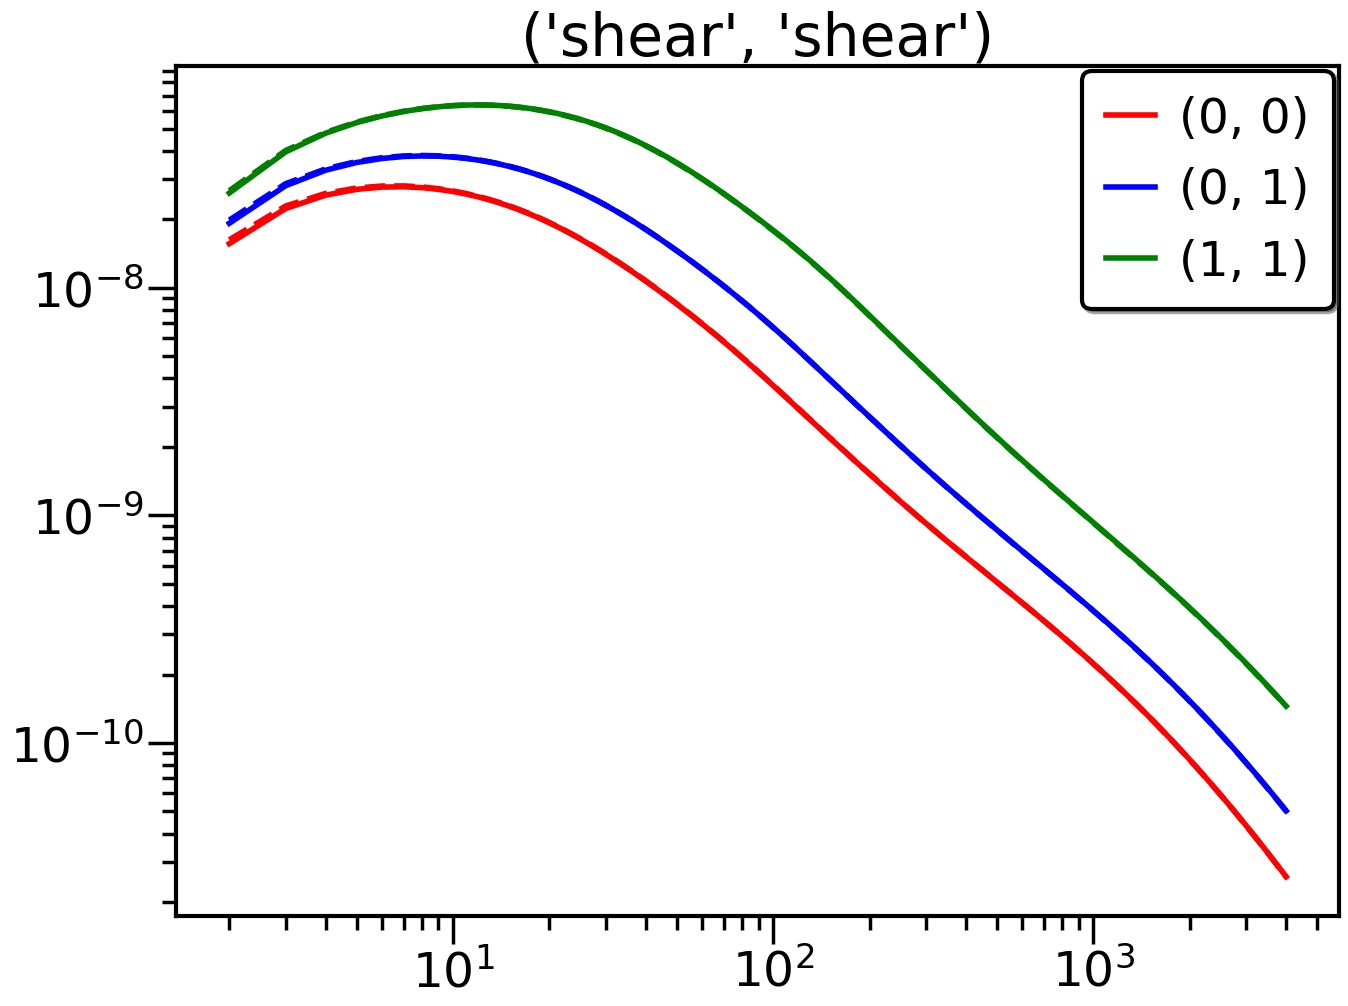

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


[3.73010963e-08 5.60829313e-08 7.11187682e-08 ... 3.43992057e-10
 3.43851235e-10 3.43710417e-10]
[3.85556883e-12 5.99368020e-12 7.86699693e-12 ... 1.51568287e-13
 1.51522787e-13 1.51477288e-13]
[8.87401515e-08 1.34277901e-07 1.71421186e-07 ... 1.13767674e-09
 1.13724578e-09 1.13681484e-09]
[2.64730055e-09 4.12612778e-09 5.43057187e-09 ... 1.20992305e-10
 1.20955445e-10 1.20918699e-10]


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


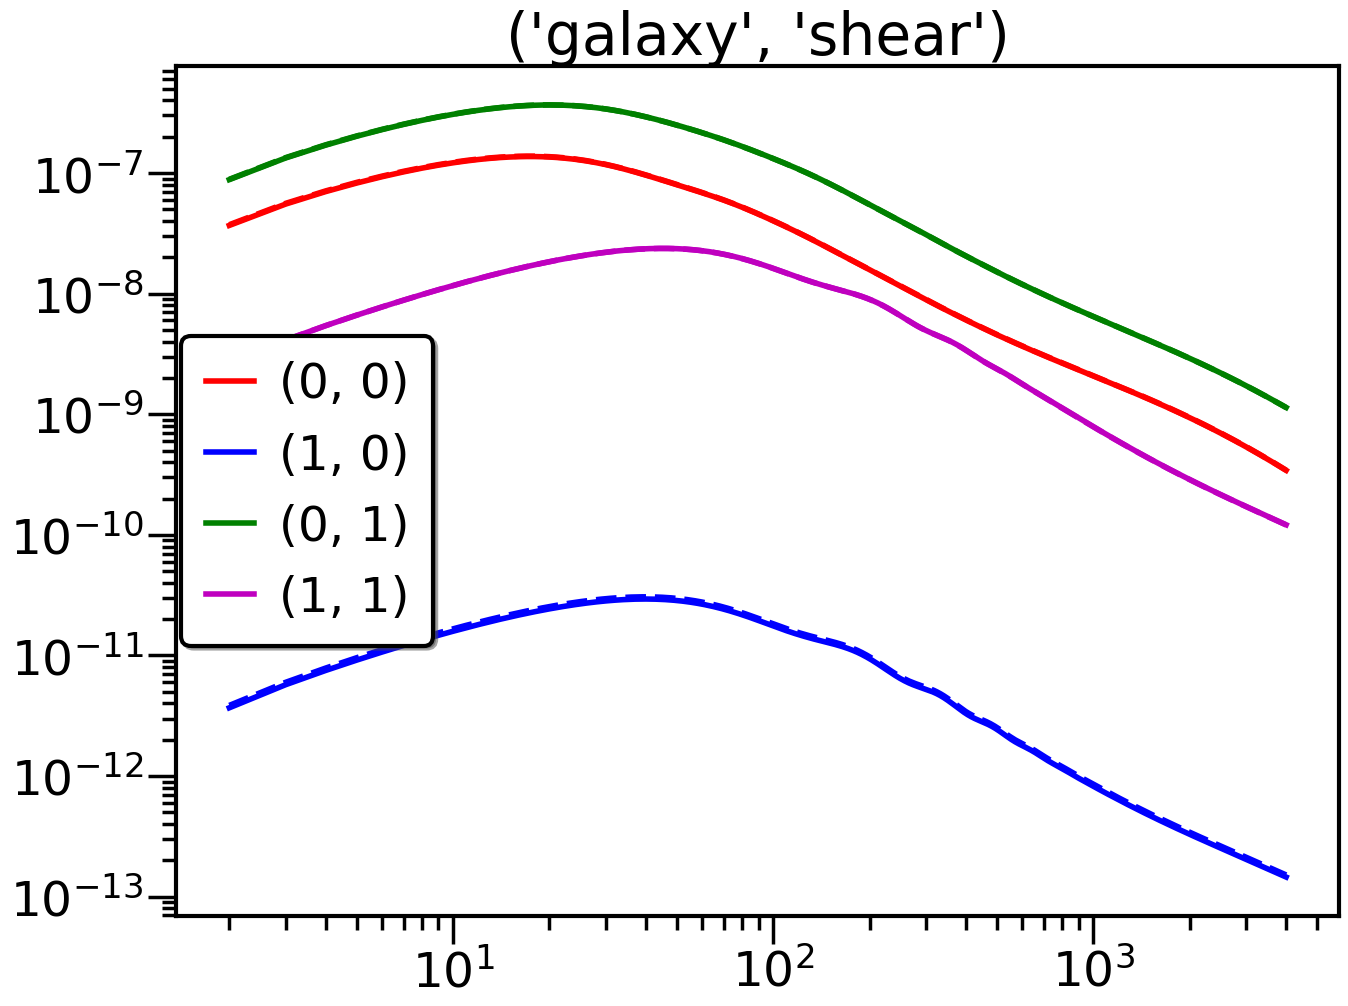

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


[9.93492152e-07 1.32088636e-06 1.61340796e-06 ... 1.04891267e-08
 1.04851587e-08 1.04811908e-08]
[6.16918006e-09 8.41215783e-09 1.05455616e-08 ... 1.97693220e-10
 1.97634129e-10 1.97575038e-10]
[5.86258142e-08 8.01595141e-08 1.00776286e-07 ... 2.20159300e-09
 2.20091323e-09 2.20023602e-09]


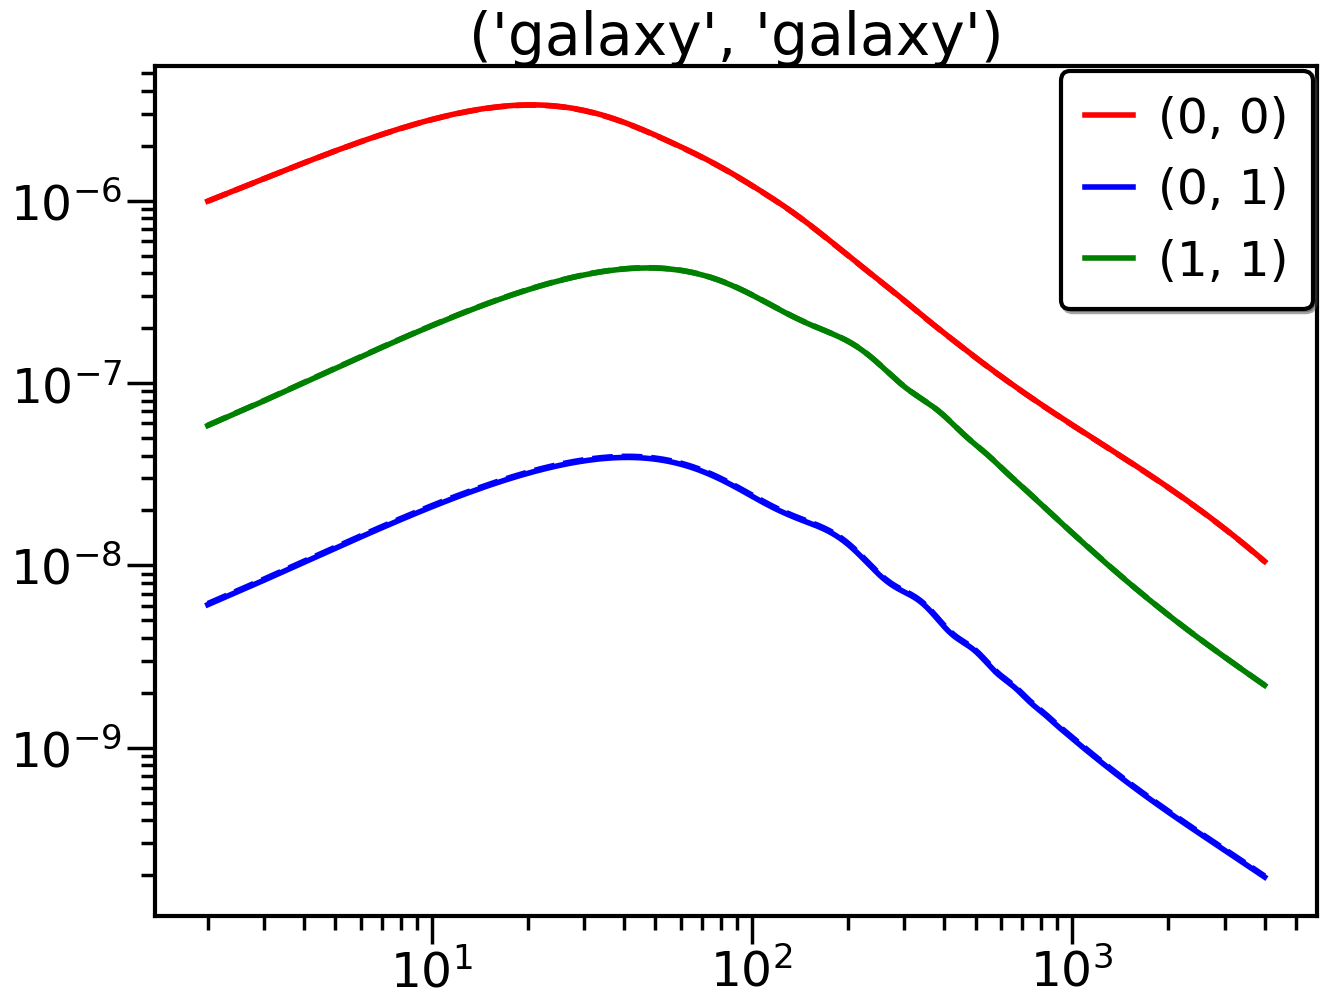

In [74]:
colors=['r','b','g','m']
for corr in kappa0.corrs:
    i=0
    for indxs in kappa0.corr_indxs[corr]:
        plot(kappa0.l,ccl_corrs[corr][indxs],label=indxs,c=colors[i])
        plot(kappa0.l,cl0G['cl'][corr][indxs].compute(),'--',c=colors[i])
        print(cl0G['cl'][corr][indxs].compute())
        i+=1
    legend()
    title(corr)
    loglog()
    show()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


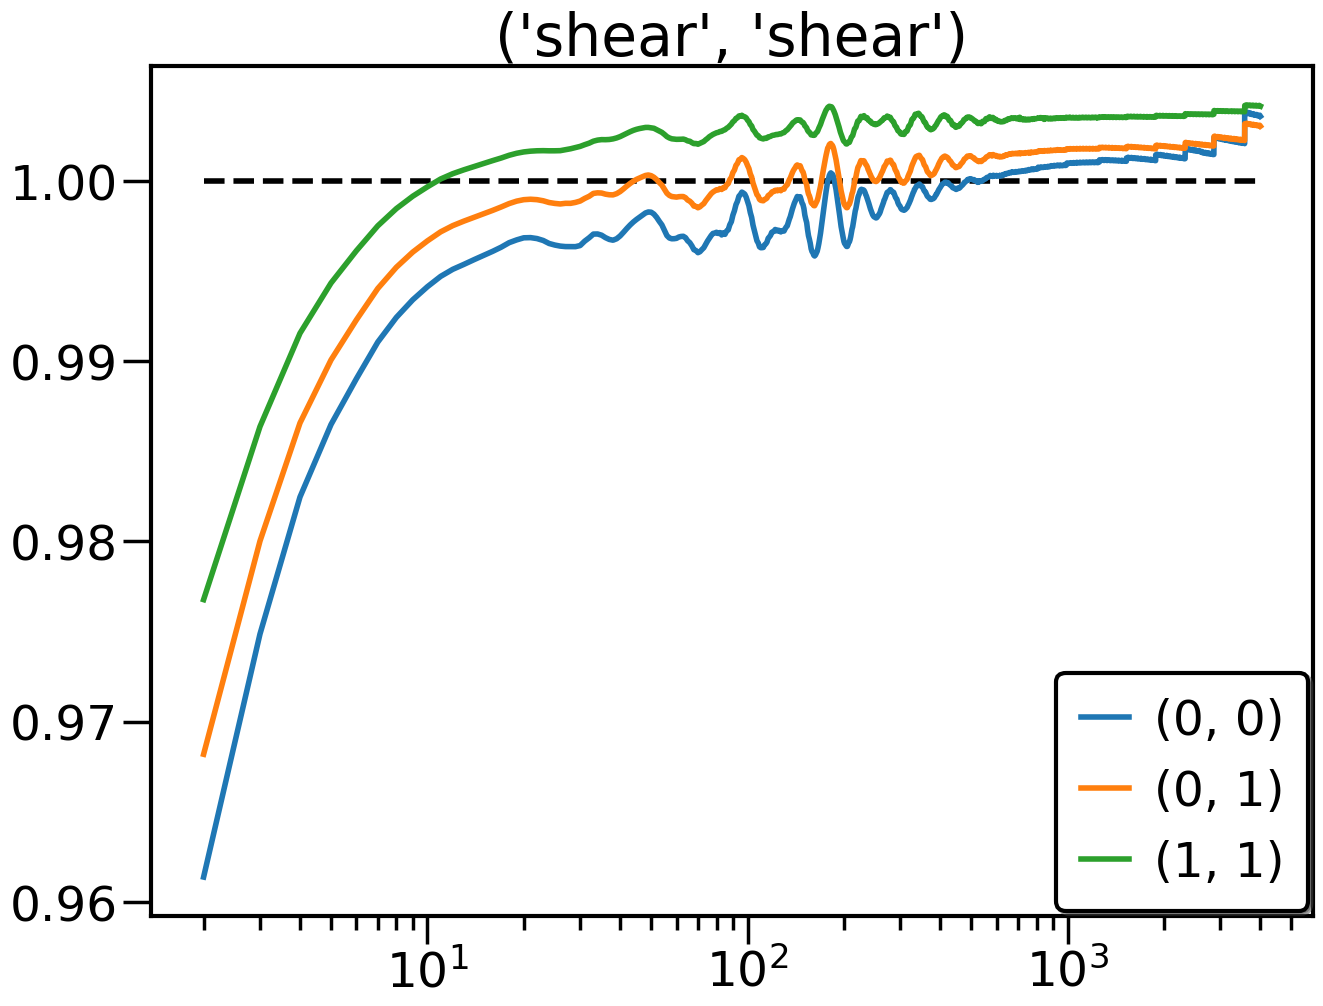

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


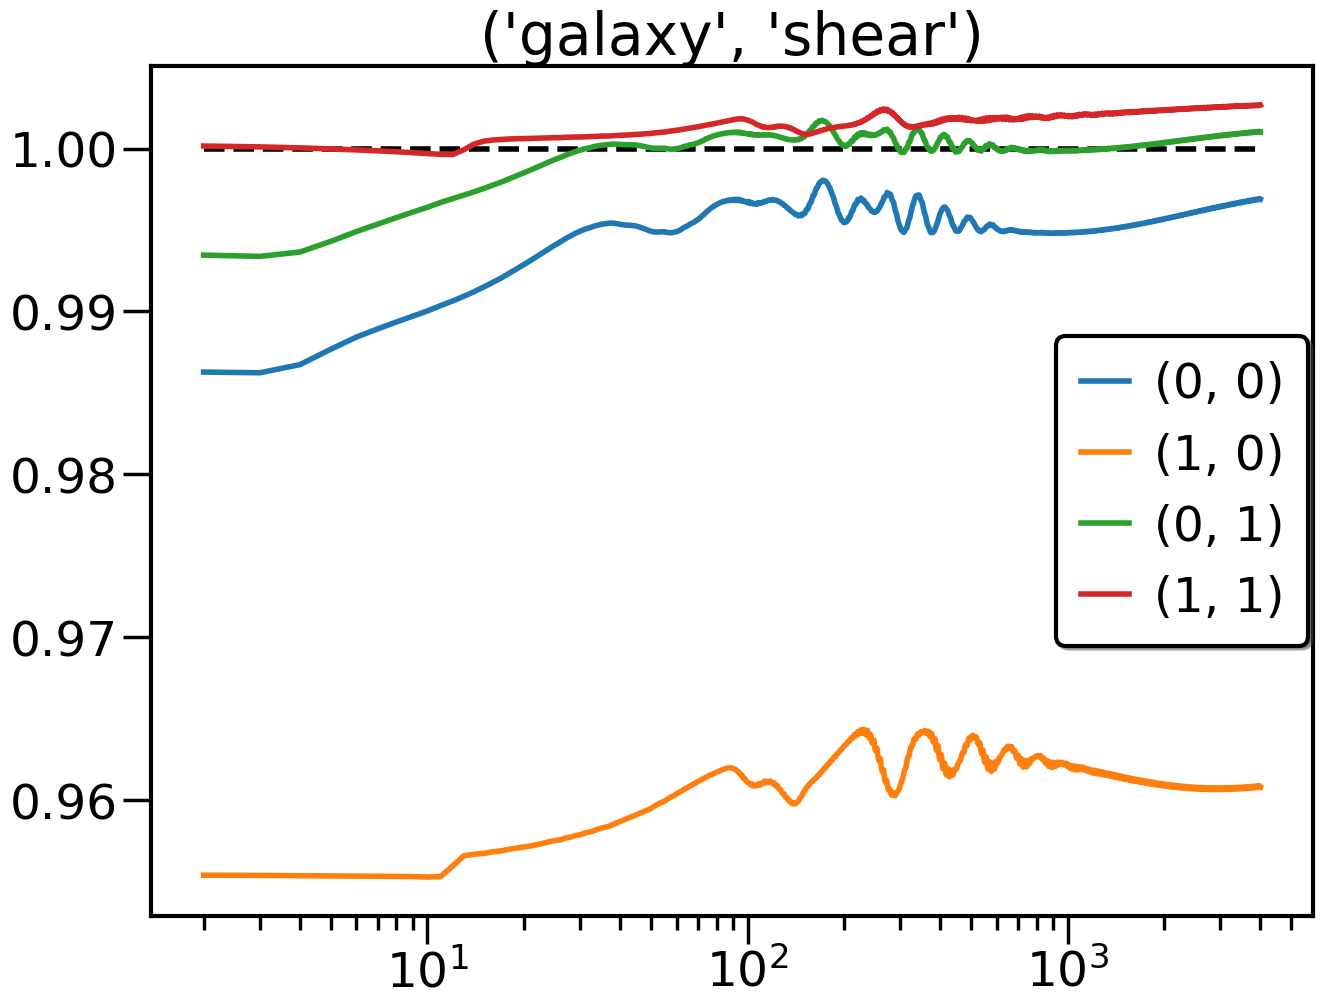

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/tracer_utils.py:160: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


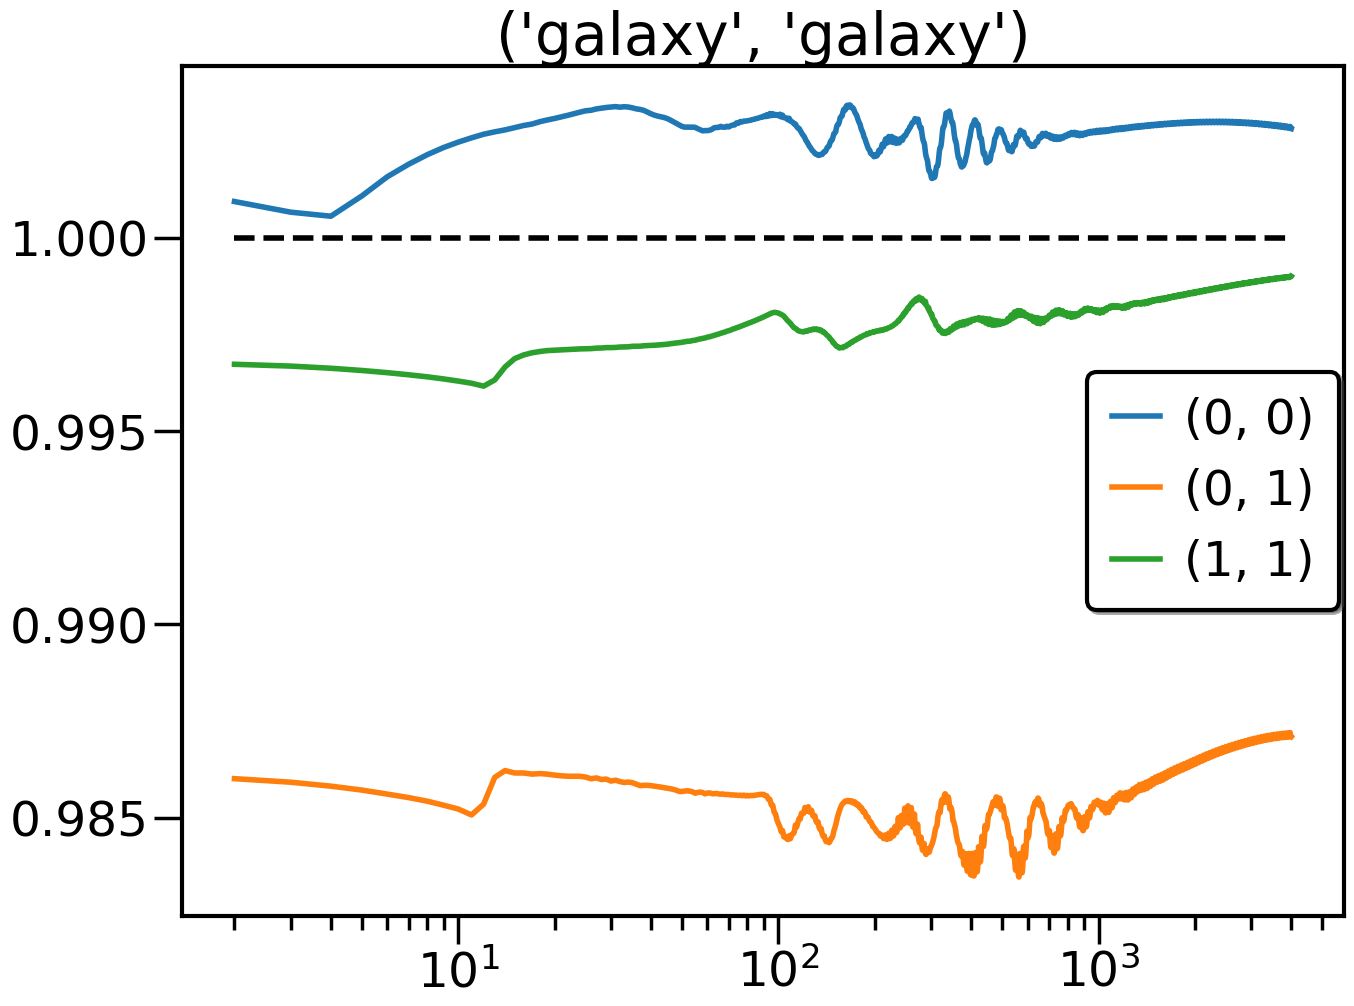

In [82]:
for corr in kappa0.corrs:
    for indxs in kappa0.corr_indxs[corr]:
        plot(kappa0.l,ccl_corrs[corr][indxs]/cl0G['cl'][corr][indxs].compute(),label=indxs)
    legend()
    title(corr)
    hlines(1,kappa0.l.min(),kappa0.l.max(),ls='--',color='k')
    xscale('log')
    show()

In [76]:
pyccl_pkf=pyccl.linear_matter_power
if pk_params['non_linear']==1:
    pyccl_pkf=pyccl.nonlin_matter_power

In [77]:
kh=kappa0.Ang_PS.PS.kh
k=kh*kappa0.Ang_PS.PS.h

In [78]:
kappa0.Ang_PS.PS.h

0.6774

In [79]:
z=np.atleast_1d([1])
ps_ccl= pyccl_pkf(cosmo_ccl,k,1./(1+z[0]))*kappa0.Ang_PS.PS.h**3
ps_skylens,k=kappa0.Ang_PS.PS.camb_pk(z=z)

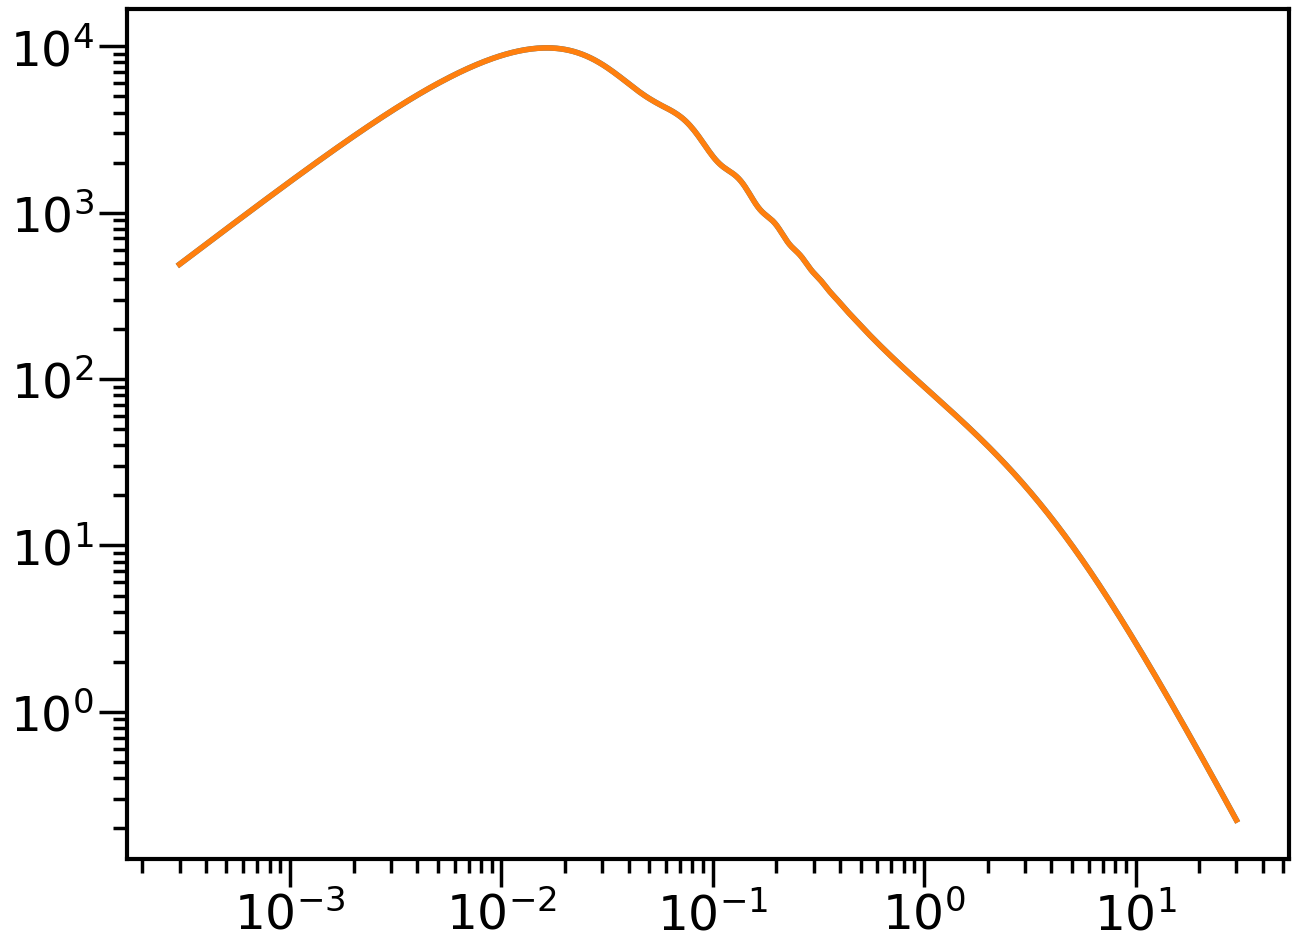

[]

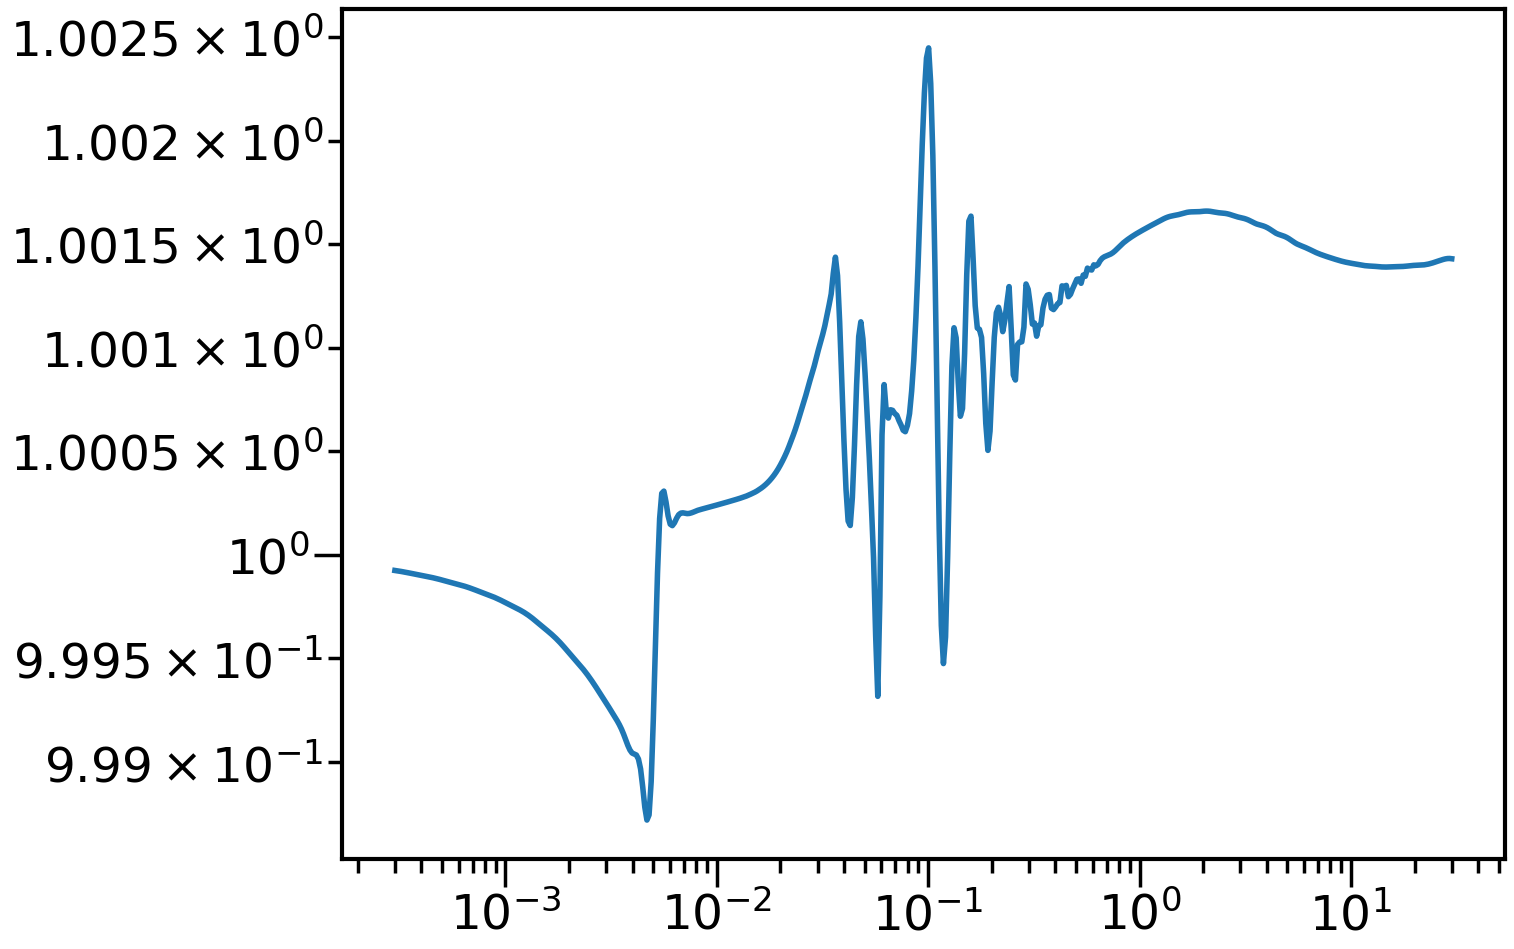

In [80]:
plot(k,ps_ccl)
plot(kh,ps_skylens[0])
loglog()
show()
plot(k,ps_ccl/ps_skylens[0])
loglog()

In [81]:
crash

NameError: name 'crash' is not defined

In [ ]:
z0=1100
z_cmb=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=26,nbins=1)

In [ ]:
from power_spectra import *

In [ ]:
# pk_params=copy.deepcopy(kappa0.Ang_PS.PS.pk_params)
# pk_params['non_linear']=1
# pk_params['pk_func']='camb_pk'

cosmo_params=kappa0.Ang_PS.PS.cosmo_params
cosmo_params['As']=cosmo_params['Ase9']*1.e-9

In [ ]:
PS=Power_Spectra(cosmo_params=cosmo_params,cosmo=kappa0.Ang_PS.PS.cosmo)
l,cl2=PS.kappa_cl(n_zl=100,log_zl=True,zl_min=1.e-4,zl_max=1100,pk_func=PS.camb_pk,l=kappa0.l)

In [ ]:
kappa0_cmb=Skylens(zk_bins=z_cmb,do_cov=do_cov,bin_cl=bin_cl,l_bins=None,l=l0, zg_bins=None,#z_PS=zg['z'],
               use_window=False,do_pseudo_cl=False,galaxy_bias_func='constant_bias',corrs=[corr_kk],
                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,power_spectra_kwargs=power_spectra_kwargs)#f_sky=0.35,sigma_gamma=0.37)
%time cl0G=kappa0_cmb.cl_tomo() 
cl_cmb=cl0G['cl'][corr_kk][(0,0)].compute()

In [ ]:
ccl_tracers={}
ccl_tracers['cmbl']=ccl.CMBLensingTracer(cosmo_ccl,z0)
ccl_cmb=ccl.angular_cl(cosmo_ccl, ccl_tracers['cmbl'],ccl_tracers['cmbl'], kappa0.l)

In [ ]:
plot(kappa0.l,cl_cmb/ccl_cmb-1)
# plot(kappa0.l,ccl_cmb)
# loglog()
xscale('log')

In [ ]:
import camb

In [ ]:
#Set up a new set of parameters for CAMB
cosmo_params=kappa0.Ang_PS.PS.cosmo_params
pars = camb.CAMBparams()
h=cosmo_params['h']

pars.set_cosmology(H0=h*100,
                    ombh2=cosmo_params['Omb']*h**2,
                    omch2=(cosmo_params['Om']-cosmo_params['Omb'])*h**2,
                    mnu=cosmo_params['mnu'],tau=cosmo_params['tau']
                    ) #    omk=cosmo_params['Omk'], )
pars.set_for_lmax(4000, lens_potential_accuracy=1)
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
cl_camb = results.get_lens_potential_cls(lmax=4000)[kappa0.l,0]

In [ ]:
plot(kappa0.l,cl_cmb*2/np.pi/cl_camb)
xscale('log')

In [ ]:
plot(l,cl2)
plot(kappa0.l,cl_cmb,'--')
# plot(kappa0.l,ccl_cmb,':')
xscale('log')
yscale('log')

In [ ]:
cl2/cl_cmb

In [ ]:
f2=spin_factor(kappa0.l,tracer='kappa')

In [ ]:
# plot(l,cl2/cl_cmb-1)
plot(l,cl_cmb/ccl_cmb)
plot(l,cl_cmb*2/np.pi/cl_camb)
xscale('log')
yscale('log')

In [ ]:
#Hankel Transform setup
l_max=1e4
l_min=2
l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),3.e4)))   #np.arange(l_min,l_max)
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [ ]:
do_sample_variance=False
use_window=False
tidal_SSV=False
do_SSV=False
f_sky=0.3

In [ ]:
XI_H =cov_3X2(zs_bins=zs_bin1,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,
              do_sample_variance=do_sample_variance,use_window=use_window,
              power_spectra_kwargs=power_spectra_kwargs,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,sigma_gamma=sigma_gamma)#ns=np.inf)

In [ ]:
%time clG=XI_H.xi_tomo()
%time clH=clG['stack'].compute()

In [ ]:
%time xiHG=XI_H.xi_tomo()
%time xiH=xiHG['stack'].compute()


In [ ]:
sn=XI_H.SN[('shear','shear')][0]

In [ ]:
c2=covariance_brute_force(l=l0,cl12=np.ones_like(l0)*sn**2,theta=XI_H.HT.theta[(2,2)])

In [ ]:
m1_m2=(2,2)
c2b=XI_H.binning.bin_2d(cov=c2,bin_utils=XI_H.xi_bin_utils[m1_m2])

In [ ]:
norm=4*np.pi*f_sky

In [ ]:
plot(thb,np.diag(c2b/norm)*2)
plot(thb,np.diag(xiH['cov'][:20,:20]),'--')
xscale('log')
yscale('log')

In [ ]:
dthb=th_bins[1:]-th_bins[:-1]

In [ ]:
n_gal=26 #DES first bin
n_gal_rad=n_gal*60.*60./d2r**2

In [ ]:
norm=4*np.pi*f_sky

In [ ]:
n_gal_rad

In [ ]:
N1=2*np.pi*norm*n_gal_rad**2
N2=(thb*dthb*d2r**2)**2
N2/=thb*dthb*d2r**2

In [ ]:
6./d2r

In [ ]:
SN22=sigma_e**4/N1/N2

In [ ]:
plot(thb,np.diag(xiH['cov'][:20,:20])*2,'--')
plot(thb,SN22,':')
xscale('log')
yscale('log')

In [ ]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'Ase9':2.2,'mnu':0,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
cosmo_fid['Oml']=1.-cosmo_fid['Om']-cosmo_fid['Omk']

In [ ]:
nk=1000
k=np.logspace(-4,1.5,nk)
nz=20
z=np.linspace(0.1,1,nz)

In [ ]:
pyccl_pkf=pyccl.linear_matter_power
# if pk_params['non_linear']==1:
#     pyccl_pkf=pyccl.nonlin_matter_power

In [ ]:
pyccl_pkf

In [ ]:
cosmo_params_ccl1={'Omega_c':cosmo_fid['Omd'],
                  'Omega_b':cosmo_fid['Omb'],
                  'h':cosmo_fid['h'],
#                   'sigma8':0.81,
                  'A_s':cosmo_fid['Ase9']*1.e-9,
                  'n_s': cosmo_fid['ns'],
                  'm_nu':cosmo_fid['mnu'],
                 'transfer_function':'boltzmann_camb', 'matter_power_spectrum':'linear'}
cosmo_ccl1 = ccl.Cosmology(**cosmo_params_ccl1)

cosmo_params_ccl2={'Omega_c':cosmo_fid['Omd'],
                  'Omega_b':cosmo_fid['Omb'],
                  'h':cosmo_fid['h'],
                  'sigma8':.8388416604111133,
#                   'A_s':cosmo_fid['Ase9']*1.e-9,
                  'n_s': cosmo_fid['ns'],
                  'm_nu':cosmo_fid['mnu'],
                   'T_CMB':2.728,
                 'transfer_function':'eisenstein_hu', 'matter_power_spectrum':'linear'} #eisenstein_hu
cosmo_ccl2 = ccl.Cosmology(**cosmo_params_ccl2)

In [ ]:
cosmo_ccl2

In [ ]:
ccl.sigma8(cosmo_ccl2)

In [ ]:
ps1=np.zeros((nz,nk))
for i in np.arange(nz):
    ps1[i]= pyccl_pkf(cosmo_ccl1,k,1./(1+z[i]))

In [ ]:
ps2=np.zeros((nz,nk))
for i in np.arange(nz):
    ps2[i]= pyccl_pkf(cosmo_ccl2,k,1./(1+z[i]))

In [ ]:
i=0
plot(k,ps1[i])
plot(k,ps2[i])
loglog()

In [ ]:
for i in np.arange(nz):
    plot(k,ps1[i]/ps2[i])
loglog()

In [ ]:
for i in np.arange(1):
    plot(k,ps1[i]-ps2[i])
    plot(k,ps2[i]-ps1[i])
    plot(k,ps1[i])
loglog()

In [ ]:
from hankel_transform import *

In [ ]:
import cosmology
reload(cosmology)
from cosmology import *

In [ ]:
cosmo_new=cosmology(cosmo_params=cosmo_fid,h_inv=False)

In [ ]:
cosmo_new.h

In [ ]:
cosmo_fid

In [ ]:
cosmo_new.H0

In [ ]:
dc1=cosmo.comoving_distance(z=z)
dc2=cosmo_new.DC(z=z)
plot(z,dc1)
plot(z,dc2/.677,'--')
loglog()

In [ ]:
class pk_eu(): #eisenstein_hu power spectra https://arxiv.org/pdf/astro-ph/9709112.pdf
    def __init__(self,cosmo_params=cosmo_fid,k=[]):
        self.k=k
        self.T_cmb=2.728 #FIXME.. make this a param
        self.theta=self.T_cmb/2.7
        self.h=cosmo_params['h']
        self.As=cosmo_params['Ase9']*1.e-9
        self.ns=cosmo_params['ns']
        self.Omega_m=cosmo_params['Om']
        self.Omega_b=cosmo_params['Omb']
        self.Omega_c=cosmo_params['Omd']
        self.Om_h2=self.Omega_m*(self.h**2)
        self.Ob_h2=self.Omega_b*(self.h**2)
        self.c=3*10**5
        
    def z_eq(self):
        self.z_eq=2.5*1.e4*self.Om_h2*(self.theta**-4)
        self.k_eq=self.k_z(self.z_eq) #np.sqrt(2*z_eq*Om_h2*100**2)
        self.R_eq=self.R_z(self.z_eq)
            
    def k_z(self,z):
        return np.sqrt(2*z*self.Om_h2*100**2/self.c**2)
    
    def z_drag(self):
        b1=0.313*self.Om_h2**-0.419*(1+ 0.607*(self.Om_h2)**0.674)
        b2=0.238*(self.Om_h2)**.223
        self.zd = 1291/(1 + 0.659*(self.Om_h2)**0.828)*(self.Om_h2**.251)*(1 + b1*self.Ob_h2**b2)
        self.Rd=self.R_z(self.zd)
        
    def R_z(self,z): #ratio of baryon-photon momentum density 
        R=31.5*self.Ob_h2*1e3/(z*self.theta**4)
        return R
    def k_silk(self):
        self.k_s = 1.6*(self.Ob_h2**0.52)*(self.Om_h2**0.73)*(1 + (10.4*self.Om_h2)**(-.95))
        
    def s_drag(self): #sound horizon drag
        self.sd=2/3/self.k_eq*np.sqrt(6/self.R_eq)*np.log((np.sqrt(1+self.Rd)+np.sqrt(self.Rd+self.R_eq))/(1+np.sqrt(self.R_eq)))
    
    
    def transfer_0(self,alpha_c,beta_c):
        q=self.k/13.41/self.k_eq
        e=2.71828
        C=14.2/alpha_c+386/(1+69.9*q**1.08)
        T0=np.log(e+1.8*beta_c*q)
        T0=T0/(T0+C*q**2)
        return T0
    
    def transfer_cdm(self):
        a1=(46.9*self.Om_h2)**0.670*(1+(32.1*self.Om_h2)**(-0.532))
        a2=(12.0*self.Om_h2)**0.424*(1+(45.0*self.Om_h2)**(-0.582))
        bf=self.Ob_h2/self.Om_h2
        alpha_c=a1**-bf*a2**(-bf**3)
        
        b1 = 0.944*(1 + (458*self.Om_h2)**-.708)**-1
        b2 = (0.395*self.Om_h2)**-.0266
        beta_c=1/(1+b1*((1-bf)**b2)-1)
#         q=self.k/13.41/self.k_eq
        f=1./(1+(self.k*self.sd/5.4)**4)
        self.transfer_c=f*self.transfer_0(1,beta_c)+(1-f)*self.transfer_0(alpha_c,beta_c)
#         ac*(np.log(1.8*bc*q))/14.2/q**2
        
    def transfer_baryon(self):
        def G_Y(y):
            sy=np.sqrt(1+y)
            return y*(-6*sy+(2+3*y)*np.log((sy+1)/(sy-1)))
        alpha_b=2.07*self.k_eq*self.sd*(1+self.Rd)**(-3/4)*G_Y((1+self.z_eq)/(1+self.zd))
        beta_n=8.41*(self.Om_h2)**0.435
        beta_b=0.5+self.Omega_b/self.Omega_m+(3-2*self.Omega_b/self.Omega_m)*np.sqrt(1+(17.2*self.Om_h2)**2)
        
        ks=self.k*self.sd
        s_app=self.sd/(1+(beta_n/ks)**3)**(1./3)
        
        self.transfer_b=self.transfer_0(1,1)/(1+(ks/5.2)**2)+alpha_b/(1+(beta_b/ks)**3)*np.exp(-(self.k/self.k_s)**1.4)
        self.transfer_b*=np.sin(self.k*s_app)/self.k/s_app
        
    
    def transfer_total(self):
        self.z_eq()
        self.z_drag()
        self.s_drag()
        self.k_silk()
        self.transfer_cdm()
        self.transfer_baryon()
        t_c=self.transfer_c
        t_b=self.transfer_b
        self.t_total=self.Omega_b/self.Omega_m*t_b+self.Omega_c/self.Omega_m*t_c

    def eh_pk(self):
        self.transfer_total()
        ns1=1-self.ns
        delta_H=1#self.Omega_m**(-0.785-.05*np.log(self.Omega_m))*np.exp(-.95*ns1-0.169*ns1**2) #1.94*10**-5*
        pk=self.k**self.ns*self.t_total*self.t_total
        pk*=delta_H**2
        pk*=self.As
        pk*=2*np.pi**2
        pk*=(self.c/self.h/100)**(3+self.ns)
        self.pk=pk

In [ ]:
#https://nbodykit.readthedocs.io/en/latest/_modules/nbodykit/cosmology/power/transfers.html#EisensteinHu

In [ ]:
class EisensteinHu(object):
    def __init__(self, cosmo, redshift):
        self.cosmo = cosmo
        self.redshift = redshift

        self.Obh2 = cosmo.Omb * cosmo.h ** 2
        self.Omh2 = cosmo.Om * cosmo.h ** 2
        self.f_baryon = cosmo.Omb / cosmo.Om
        self.theta_cmb = cosmo.Tcmb / 2.7

        # redshift and wavenumber of equality
        self.z_eq = 2.5e4 * self.Omh2 * self.theta_cmb ** (-4) # this is 1 + z
        self.k_eq = 0.0746 * self.Omh2 * self.theta_cmb ** (-2) # units of 1/Mpc

        # sound horizon and k_silk
        self.z_drag_b1 = 0.313 * self.Omh2 ** -0.419 * (1 + 0.607 * self.Omh2 ** 0.674)
        self.z_drag_b2 = 0.238 * self.Omh2 ** 0.223
        self.z_drag    = 1291 * self.Omh2 ** 0.251 / (1. + 0.659 * self.Omh2 ** 0.828) * \
                           (1. + self.z_drag_b1 * self.Obh2 ** self.z_drag_b2)

        self.r_drag = 31.5 * self.Obh2 * self.theta_cmb ** -4 * (1000. / (1+self.z_drag))
        self.r_eq   = 31.5 * self.Obh2 * self.theta_cmb ** -4 * (1000. / self.z_eq)

        self.sound_horizon = 2. / (3.*self.k_eq) * numpy.sqrt(6. / self.r_eq) * \
                    numpy.log((numpy.sqrt(1 + self.r_drag) + numpy.sqrt(self.r_drag + self.r_eq)) / (1 + numpy.sqrt(self.r_eq)) )
        self.k_silk = 1.6 * self.Obh2 ** 0.52 * self.Omh2 ** 0.73 * (1 + (10.4*self.Omh2) ** -0.95)

        # alpha_c
        alpha_c_a1 = (46.9*self.Omh2) ** 0.670 * (1 + (32.1*self.Omh2) ** -0.532)
        alpha_c_a2 = (12.0*self.Omh2) ** 0.424 * (1 + (45.0*self.Omh2) ** -0.582)
        self.alpha_c = alpha_c_a1 ** -self.f_baryon * alpha_c_a2 ** (-self.f_baryon**3)

        # beta_c
        beta_c_b1 = 0.944 / (1 + (458*self.Omh2) ** -0.708)
        beta_c_b2 = 0.395 * self.Omh2 ** -0.0266
        self.beta_c = 1. / (1 + beta_c_b1 * ((1-self.f_baryon) ** beta_c_b2) - 1)

        y = self.z_eq / (1 + self.z_drag)
        alpha_b_G = y * (-6.*numpy.sqrt(1+y) + (2. + 3.*y) * numpy.log((numpy.sqrt(1+y)+1) / (numpy.sqrt(1+y)-1)))
        self.alpha_b = 2.07 *  self.k_eq * self.sound_horizon * (1+self.r_drag)**-0.75 * alpha_b_G

        self.beta_node = 8.41 * self.Omh2 ** 0.435
        self.beta_b    = 0.5 + self.f_baryon + (3. - 2.*self.f_baryon) * numpy.sqrt( (17.2*self.Omh2) ** 2 + 1 )

    def __call__(self, k):
        if numpy.isscalar(k) and k == 0.:
            return 1.0

        k = numpy.asarray(k)
        # only compute k > 0 modes
        valid = k > 0.

        k = k[valid] * self.cosmo.h # now in 1/Mpc
        q = k / (13.41*self.k_eq)
        ks = k*self.sound_horizon

        T_c_ln_beta   = numpy.log(numpy.e + 1.8*self.beta_c*q)
        T_c_ln_nobeta = numpy.log(numpy.e + 1.8*q);
        T_c_C_alpha   = 14.2 / self.alpha_c + 386. / (1 + 69.9 * q ** 1.08)
        T_c_C_noalpha = 14.2 + 386. / (1 + 69.9 * q ** 1.08)

        T_c_f = 1. / (1. + (ks/5.4) ** 4)
        f = lambda a, b : a / (a + b*q**2)
        T_c = T_c_f * f(T_c_ln_beta, T_c_C_noalpha) + (1-T_c_f) * f(T_c_ln_beta, T_c_C_alpha)

        s_tilde = self.sound_horizon * (1 + (self.beta_node/ks)**3) ** (-1./3.)
        ks_tilde = k*s_tilde

        T_b_T0 = f(T_c_ln_nobeta, T_c_C_noalpha)
        T_b_1 = T_b_T0 / (1 + (ks/5.2)**2 )
        T_b_2 = self.alpha_b / (1 + (self.beta_b/ks)**3 ) * numpy.exp(-(k/self.k_silk) ** 1.4)
        T_b = numpy.sinc(ks_tilde/numpy.pi) * (T_b_1 + T_b_2)

        T = numpy.ones(valid.shape)
        T[valid] = self.f_baryon*T_b + (1-self.f_baryon)*T_c;
        return T * self.cosmo.scale_independent_growth_factor(self.redshift)

In [ ]:
eu=EisensteinHu(cosmo=cosmo,redshift=0)

In [ ]:
pke=pk_eu(k=k)#/cosmo_fid['h'])

In [ ]:
pke.k_eq,pke.k_s

In [ ]:
pke.eh_pk()

In [ ]:
i=0
ns=cosmo_fid['ns']
plot(k,k**3*ps2[0])
plot(k,k**3*pke.pk,'--')
loglog()

In [ ]:
i=0
ns=cosmo_fid['ns']
plot(k,ps2[0]/pke.pk)
loglog()

In [ ]:
1./ccl.growth_factor(cosmo_ccl1,a=1/1100)

In [ ]:
from colossus.cosmology import cosmology as col_cosmology


In [ ]:
col_cosmo = col_cosmology.setCosmology('planck15')


In [ ]:
col_Pk = col_cosmo.matterPowerSpectrum(k,model='eisenstein98')


In [ ]:
plot(k,col_Pk/ps2[0])
loglog()